# QUESTION 1 (ID3)

In [2]:
import pandas as pd
import numpy as np
#loading iris
train_data_m = pd.read_csv("Iris.csv", usecols=['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm', 'Species'])
train_data_m.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
#splitting
train_data = train_data_m.sample(frac=0.8, random_state=42)  
test_data = train_data_m.drop(train_data.index)  

class_list = train_data_m['species'].unique() 

#calculating mean of each attribute
numerical_columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
attribute_means = train_data[numerical_columns].mean()

In [3]:
class_list

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [4]:
#calculating entropy and gain
def entropy(y):
    _, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    return -np.sum(probabilities * np.log2(probabilities))


#calculating information gain for each attribute and threshold
def information_gain(X, y, feature, threshold=None):
    if threshold is not None:
        left_mask = X[feature] <= threshold
        left_entropy = entropy(y[left_mask])
        right_entropy = entropy(y[~left_mask])
        n = len(y)
        n_left = sum(left_mask)
        n_right = n - n_left
        return entropy(y) - (n_left / n) * left_entropy - (n_right / n) * right_entropy
    else:
        return entropy(y) - sum(len(v) / len(y) * entropy(v) for _, v in y.groupby(X[feature]))

In [5]:
def find_best_split(X, y):
    best_gain = -1
    best_feature = None
    best_threshold = None
    #loop through each feature to find the best split
    for feature in X.columns:
        if feature in numerical_columns:
            threshold = X[feature].mean() #using mean as threshold
            gain = information_gain(X, y, feature, threshold) #calculating gain
            if gain > best_gain:
                best_gain = gain
                best_feature = feature
                best_threshold = threshold
        else:
            gain = information_gain(X, y, feature) 
            if gain > best_gain:
                best_gain = gain
                best_feature = feature
                best_threshold = None

    return best_feature, best_threshold, best_gain

In [6]:
def id3(X, y, max_depth=5, min_samples_split=2, min_info_gain=0.0, depth=0):
    #checking stopping criteria
    if len(y) < min_samples_split or depth >= max_depth or len(np.unique(y)) == 1:
        return {'label': y.mode().iloc[0]}
    
    feature, threshold, info_gain = find_best_split(X, y)

    if info_gain <= min_info_gain:
        return {'label': y.mode().iloc[0]}
    #printing thresholds at ech depth
    print(f"Depth: {depth} | Feature: {feature} | Threshold: {threshold}") 
    left_mask = X[feature] <= threshold
    right_mask = ~left_mask

    # recursively building left and right trees
    left_tree = id3(X[left_mask], y[left_mask], max_depth, min_samples_split, min_info_gain, depth + 1)
    right_tree = id3(X[right_mask], y[right_mask], max_depth, min_samples_split, min_info_gain, depth + 1)
    #returning the tree
    return {
        'feature': feature,
        'threshold': threshold,
        'left': left_tree,
        'right': right_tree
    }

In [7]:
def predict_sample(node, sample):
    while 'label' not in node:
        if sample[node['feature']] <= node['threshold']:
            node = node['left']
        else:
            node = node['right']
    return node['label']

def predict(tree, X):
    return X.apply(lambda x: predict_sample(tree, x), axis=1)

In [8]:
#print tracing of how the tree was built
tree = id3(train_data[numerical_columns], train_data['species'], max_depth=3)
tree


Depth: 0 | Feature: petal_length | Threshold: 3.6691666666666665
Depth: 1 | Feature: petal_length | Threshold: 1.6666666666666667
Depth: 2 | Feature: sepal_width | Threshold: 3.05
Depth: 1 | Feature: petal_width | Threshold: 1.7305555555555558
Depth: 2 | Feature: petal_length | Threshold: 4.4527777777777775
Depth: 2 | Feature: sepal_width | Threshold: 3.019444444444444


{'feature': 'petal_length',
 'threshold': np.float64(3.6691666666666665),
 'left': {'feature': 'petal_length',
  'threshold': np.float64(1.6666666666666667),
  'left': {'label': 'Iris-setosa'},
  'right': {'feature': 'sepal_width',
   'threshold': np.float64(3.05),
   'left': {'label': 'Iris-versicolor'},
   'right': {'label': 'Iris-setosa'}}},
 'right': {'feature': 'petal_width',
  'threshold': np.float64(1.7305555555555558),
  'left': {'feature': 'petal_length',
   'threshold': np.float64(4.4527777777777775),
   'left': {'label': 'Iris-versicolor'},
   'right': {'label': 'Iris-versicolor'}},
  'right': {'feature': 'sepal_width',
   'threshold': np.float64(3.019444444444444),
   'left': {'label': 'Iris-virginica'},
   'right': {'label': 'Iris-virginica'}}}}

In [9]:
def evaluate(tree, X, y):
    predictions = predict(tree, X)
    accuracy = (predictions == y).mean()
    return accuracy

#training 
tree = id3(train_data.drop('species', axis=1), train_data['species'], max_depth=5, min_samples_split=2, min_info_gain=0.01)

train_accuracy = evaluate(tree, train_data.drop('species', axis=1), train_data['species'])
test_accuracy = evaluate(tree, test_data.drop('species', axis=1), test_data['species'])

#accuracy
print(f"training accuracy: {train_accuracy*100:.4f}")
print(f"testing accuracy: {test_accuracy*100:.4f}")

Depth: 0 | Feature: petal_length | Threshold: 3.6691666666666665
Depth: 1 | Feature: petal_length | Threshold: 1.6666666666666667
Depth: 2 | Feature: sepal_width | Threshold: 3.05
Depth: 1 | Feature: petal_width | Threshold: 1.7305555555555558
Depth: 2 | Feature: petal_length | Threshold: 4.4527777777777775
Depth: 3 | Feature: petal_length | Threshold: 4.755
Depth: 4 | Feature: sepal_length | Threshold: 6.314285714285714
Depth: 2 | Feature: sepal_width | Threshold: 3.019444444444444
Depth: 3 | Feature: petal_width | Threshold: 2.1733333333333333
Depth: 4 | Feature: sepal_length | Threshold: 6.800000000000001
training accuracy: 97.5000
testing accuracy: 93.3333


Depth: 0 | Feature: petal_length | Threshold: 3.6691666666666665
Depth: 1 | Feature: petal_length | Threshold: 1.6666666666666667
Depth: 2 | Feature: sepal_width | Threshold: 3.05
Depth: 1 | Feature: petal_width | Threshold: 1.7305555555555558
Depth: 2 | Feature: petal_length | Threshold: 4.4527777777777775
Depth: 3 | Feature: petal_length | Threshold: 4.755
Depth: 4 | Feature: sepal_length | Threshold: 6.314285714285714
Depth: 2 | Feature: sepal_width | Threshold: 3.019444444444444
Depth: 3 | Feature: petal_width | Threshold: 2.1733333333333333
Depth: 4 | Feature: sepal_length | Threshold: 6.800000000000001


<Figure size 640x480 with 0 Axes>

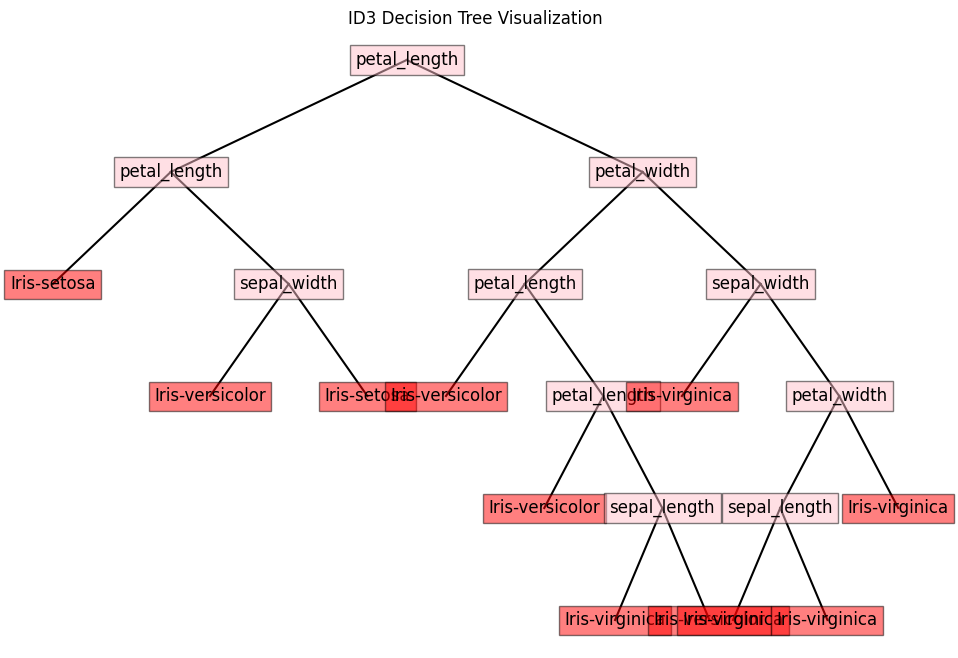

In [15]:
import matplotlib.pyplot as plt
# decision tree visualization
def plot_tree(node, depth=0, pos=None, ax=None):
    if pos is None:
        pos = [0.5, 1]
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))

    if 'label' in node:
        ax.text(pos[0], pos[1], str(node['label']), 
                bbox=dict(facecolor='red', alpha=0.5),
                horizontalalignment='center', verticalalignment='center', fontsize=12)
    else:
        ax.text(pos[0], pos[1], f'{node["feature"]}', 
                bbox=dict(facecolor='pink', alpha=0.5),
                horizontalalignment='center', verticalalignment='center', fontsize=12)
        pos_left = [pos[0] - 0.2 / (depth + 1), pos[1] - 0.2]
        pos_right = [pos[0] + 0.2 / (depth + 1), pos[1] - 0.2]
        ax.plot([pos[0], pos_left[0]], [pos[1], pos_left[1]], 'k-')
        ax.plot([pos[0], pos_right[0]], [pos[1], pos_right[1]], 'k-')
        plot_tree(node['left'], depth + 1, pos_left, ax)
        plot_tree(node['right'], depth + 1, pos_right, ax)

    return ax

tree = id3(train_data.drop('species', axis=1), train_data['species'], max_depth=5, min_samples_split=2, min_info_gain=0.01)

plt.figure()
plot_tree(tree)
plt.title("ID3 Decision Tree Visualization")
plt.axis('off')
plt.show()


# QUESTION 1 (CART)

In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
# function to find best split 
def find_best_split(X, y):
    best_feature = None
    best_threshold = None
    best_info_gain = -float('inf')
    #calculating gini 
    def gini_impurity(y):
        classes, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        return 1 - np.sum(probabilities ** 2)
    
    #calculating info gain
    def information_gain(parent, left_child, right_child):
        p = len(left_child) / len(parent)
        return gini_impurity(parent) - p * gini_impurity(left_child) - (1 - p) * gini_impurity(right_child)
    #looping through each feature
    for feature in X.columns:
        thresholds = np.unique(X[feature])
        for threshold in thresholds:
            left_mask = X[feature] <= threshold
            right_mask = ~left_mask
            
            if len(y[left_mask]) > 0 and len(y[right_mask]) > 0:
                info_gain = information_gain(y, y[left_mask], y[right_mask])
                if info_gain > best_info_gain:
                    best_feature = feature
                    best_threshold = threshold
                    best_info_gain = info_gain
    
    return best_feature, best_threshold, best_info_gain

In [18]:
def recursive_cart(X, y, depth=0, max_depth=5, min_samples_split=2, min_info_gain=0.0):
    node = {
        'X': X,
        'y': y,
        'depth': depth,
        'feature': None,
        'threshold': None,
        'left': None,
        'right': None,
        'label': None
    }
    #checking stopping criteria
    if len(y) < min_samples_split or depth >= max_depth or len(np.unique(y)) == 1:
        node['label'] = y.mode().iloc[0]
        return node

    feature, threshold, info_gain = find_best_split(X, y)
    #checking min info gain
    if info_gain <= min_info_gain:
        node['label'] = y.mode().iloc[0]
        return node

    node['feature'] = feature
    node['threshold'] = threshold
#recursively building left and right trees
    if threshold is not None:
        left_mask = X[feature] <= threshold
        right_mask = ~left_mask
        node['left'] = recursive_cart(X[left_mask], y[left_mask], depth + 1, max_depth, min_samples_split, min_info_gain)
        node['right'] = recursive_cart(X[right_mask], y[right_mask], depth + 1, max_depth, min_samples_split, min_info_gain)
    else:
        for value in X[feature].unique():
            mask = X[feature] == value
            child_node = recursive_cart(X[mask], y[mask], depth + 1, max_depth, min_samples_split, min_info_gain)
            setattr(node, f"child_{value}", child_node)

    return node

In [19]:
#predicting sample by traversing the tree
def predict_sample(node, sample):
    while node['label'] is None:
        if node['threshold'] is not None:
            if sample[node['feature']] <= node['threshold']:
                node = node['left']
            else:
                node = node['right']
        else:
            value = sample[node['feature']]
            node = getattr(node, f"child_{value}", None)
            if node is None:
                return None
    return node['label']

In [20]:
def predict(tree, X):
    return X.apply(lambda x: predict_sample(tree, x), axis=1)

In [21]:
def evaluate(tree, X, y):
    predictions = predict(tree, X)
    accuracy = (predictions == y).mean()
    return accuracy

In [22]:
#pruning tree 
def prune_tree(node, X_val, y_val):
    if node['left'] is None and node['right'] is None:
        return
    #recursively pruning left and right trees
    prune_tree(node['left'], X_val, y_val)
    prune_tree(node['right'], X_val, y_val)

    original_left = node['left']
    original_right = node['right']
    original_feature = node['feature']
    original_threshold = node['threshold']
#
    node['left'] = None
    node['right'] = None
    node['feature'] = None
    node['threshold'] = None
    node['label'] = node['y'].mode().iloc[0]
#checking accuracy before and after pruning
    accuracy_before = evaluate(tree, X_val, y_val)
    accuracy_after = evaluate(tree, X_val, y_val)

    if accuracy_after <= accuracy_before:
        node['left'] = original_left
        node['right'] = original_right
        node['feature'] = original_feature
        node['threshold'] = original_threshold
        node['label'] = None

#splitting data
X_train, X_val, y_train, y_val = train_test_split(
    train_data.drop('species', axis=1), 
    train_data['species'], 
    test_size=0.2, 
    random_state=42
)

In [23]:
tree = recursive_cart(X_train, y_train, max_depth=5, min_samples_split=2, min_info_gain=0.01)

prune_tree(tree, X_val, y_val)

train_accuracy = evaluate(tree, train_data.drop('species', axis=1), train_data['species'])
test_accuracy = evaluate(tree, test_data.drop('species', axis=1), test_data['species'])

print(f"training accuracy: {train_accuracy*100:.4f}")
print(f"testing accuracy: {test_accuracy*100:.4f}")

training accuracy: 99.1667
testing accuracy: 93.3333


<Figure size 640x480 with 0 Axes>

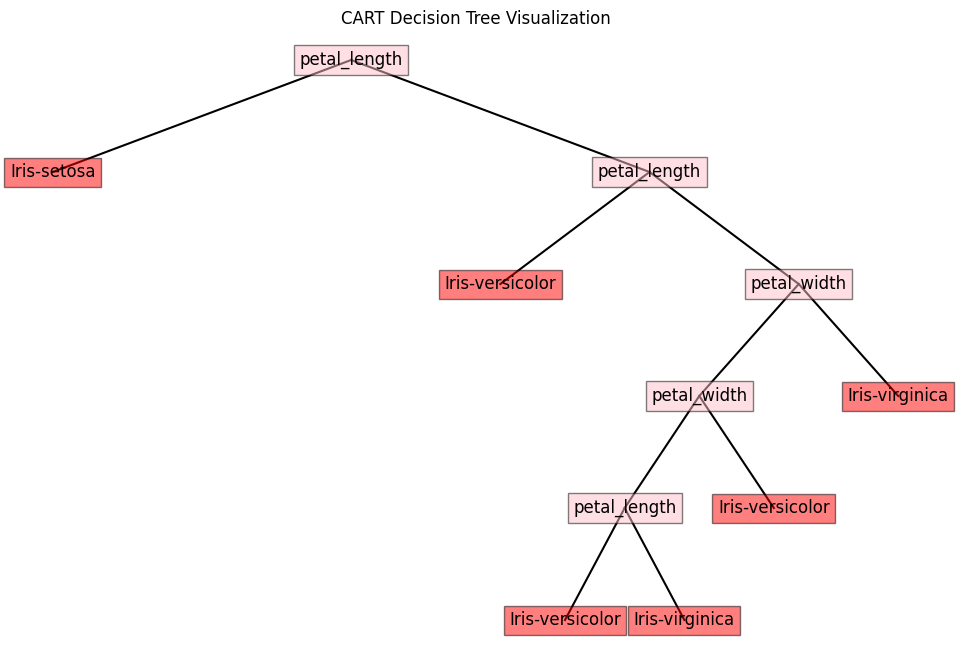

In [25]:
def plot_tree(node, depth=0, pos=None, ax=None):
    if pos is None:
        pos = []
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
    
    if node['label'] is not None:
        ax.text(pos[0], pos[1], str(node['label']), 
                bbox=dict(facecolor='red', alpha=0.5),
                horizontalalignment='center', verticalalignment='center', fontsize=12)
    else:
        ax.text(pos[0], pos[1], f'{node["feature"]}', 
                bbox=dict(facecolor='pink', alpha=0.5),
                horizontalalignment='center', verticalalignment='center', fontsize=12)
        
        # Position for left child
        pos_left = [pos[0] - 0.2 / (depth + 1), pos[1] - 0.2]
        # Position for right child
        pos_right = [pos[0] + 0.2 / (depth + 1), pos[1] - 0.2]

        # Draw lines to children
        ax.plot([pos[0], pos_left[0]], [pos[1], pos_left[1]], 'k-')
        ax.plot([pos[0], pos_right[0]], [pos[1], pos_right[1]], 'k-')

        # Recursive calls for left and right children
        plot_tree(node['left'], depth + 1, pos_left, ax)
        plot_tree(node['right'], depth + 1, pos_right, ax)

    return ax

# Call the function to plot the tree
plt.figure()
plot_tree(tree, pos=[0.5, 1])
plt.title("CART Decision Tree Visualization")
plt.axis('off')  # Hide axes
plt.show()

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score

train_predictions = predict(tree, train_data.drop('species', axis=1))
test_predictions = predict(tree, test_data.drop('species', axis=1))

train_precision = precision_score(train_data['species'], train_predictions, average='weighted')
train_recall = recall_score(train_data['species'], train_predictions, average='weighted')
train_f1 = f1_score(train_data['species'], train_predictions, average='weighted')

test_precision = precision_score(test_data['species'], test_predictions, average='weighted')
test_recall = recall_score(test_data['species'], test_predictions, average='weighted')
test_f1 = f1_score(test_data['species'], test_predictions, average='weighted')

print(f"\ntraining precision: {train_precision:.4f}")
print(f"recall: {train_recall:.4f}")
print(f"f1 score: {train_f1:.4f}\n")

print(f"testing precision: {test_precision:.4f}")
print(f"recall: {test_recall:.4f}")
print(f"f1 score: {test_f1:.4f}")


training precision: 0.9919
recall: 0.9917
f1 score: 0.9917

testing precision: 0.9436
recall: 0.9333
f1 score: 0.9331


# COMPARISON OF ID3 AND CART RESULTS

the results show that the id3 and cart algorithms achieved different training accuracies, with id3 reaching 97.5% and cart achieving 99.17%. both algorithms performed equally well on the testing dataset, with an accuracy of 93.33%. interestingly, the algorithms had different precision, recall, and f1 scores for both training and testing data.

on the training data, id3 had precision of 0.9756, recall of 0.9744, and an f1 score of 0.9740, while cart had precision of 0.9919, recall of 0.9917, and an f1 score of 0.9917. for the testing data, id3 showed precision at 0.9487, recall at 0.9444, and an f1 score of 0.9419, whereas cart had precision at 0.9436, recall at 0.9333, and an f1 score of 0.9331.

overall, both algorithms performed well, but cart showed superior performance on the training dataset, while their performance on the testing dataset was comparable, suggesting that for this particular problem, id3 and cart are effective classification methods but with notable differences in training efficiency.